# Astro II (SS2026) — Cepheid Standard Candles and Hubble's Law

**Goal.** Build a Hubble diagram using **Cepheid-calibrated distances** and study how calibration systematics propagate into $H_0$.

You will:
1. Download a public sample of Cepheid-host systems (HST Key Project style).
2. Use Cepheid distance moduli $\mu$ and convert them to distances.
3. Infer $z$ from published recession velocities.
4. Fit $H_0$ from $v$ vs. $d$.
5. Apply a Cepheid zero-point offset, then correct it and quantify the change in $H_0$.

This notebook is designed for JupyterLite (browser-only): it uses **NumPy**, **Matplotlib**, and **ipywidgets**.


In [19]:
import numpy as np
import math
import matplotlib.pyplot as plt

from ipywidgets import VBox, HBox, FloatSlider, IntSlider, Checkbox, Dropdown, Button, Output, HTML
from IPython.display import display, clear_output

# Constants
c_km_s = 299792.458  # speed of light in km/s

plt.rcParams['figure.dpi'] = 110


## 0. Background and historical thread

Hubble’s plot combines two measurements:

- **Velocity axis:** from redshift spectroscopy.
- **Distance axis:** from the distance ladder.

A key rung is the Cepheid period-luminosity relation discovered by **Henrietta Swan Leavitt**.
For Cepheids, the logic is:
$$
M = a\,(\log_{10}P-1)+b, \qquad \mu = m-M, \qquad d(\mathrm{Mpc})=10^{(\mu-25)/5}.
$$

In this notebook we use a compact public sample of **Cepheid-host systems** with published velocities and Cepheid-based distances, then deliberately apply a Cepheid zero-point offset to study a classic systematic.

Low-redshift relation used here:
$$
v \approx cz, \qquad v \approx H_0 d.
$$


## 1. Load Cepheid-standard-candle data and reconstruct redshift

We download a public HST Key Project style sample where distances come from Cepheid calibration.

For each host system we use
$$
\mu_{\mathrm{Ceph}} = 5\log_{10}(d/\mathrm{Mpc})+25, \qquad z = \frac{v}{c}.
$$


Loaded 24 Cepheid-host systems, source: downloaded from https://csvbase.com/rmirror/hubble
Cepheid modulus range: 26.51–31.71 mag
Distance range: 2.00–21.98 Mpc
Velocity range: 80–1794 km/s


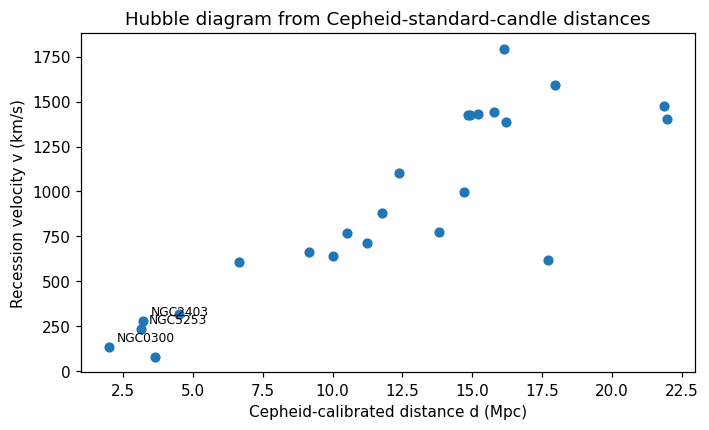

In [20]:
import json
from urllib.request import Request, urlopen

# Public sample: HST Key Project style hosts with Cepheid-calibrated distances and velocities.
CEPHEID_HOST_API_URL = "https://csvbase.com/rmirror/hubble"

FALLBACK_ROWS = [
    ("NGC0300", 2.00, 133.0), ("NGC0925", 9.16, 664.0), ("NGC1326A", 16.14, 1794.0),
    ("NGC1365", 17.95, 1594.0), ("NGC1425", 21.88, 1473.0), ("NGC2403", 3.22, 278.0),
    ("NGC2541", 11.22, 714.0), ("NGC2090", 11.75, 882.0), ("NGC3031", 3.63, 80.0),
    ("NGC3198", 13.80, 772.0), ("NGC3351", 10.00, 642.0), ("NGC3368", 10.52, 768.0),
    ("NGC3621", 6.64, 609.0), ("NGC4321", 15.21, 1433.0), ("NGC4414", 17.70, 619.0),
    ("NGC4496A", 14.86, 1424.0), ("NGC4548", 16.22, 1384.0), ("NGC4535", 15.78, 1444.0),
    ("NGC4536", 14.93, 1423.0), ("NGC4639", 21.98, 1403.0), ("NGC4725", 12.36, 1103.0),
    ("IC4182", 4.49, 318.0), ("NGC5253", 3.15, 232.0), ("NGC7331", 14.72, 999.0),
]

def fetch_rows(url=CEPHEID_HOST_API_URL):
    rows = []
    next_url = url
    while next_url:
        req = Request(next_url, headers={"Accept": "application/json", "User-Agent": "Mozilla/5.0"})
        with urlopen(req, timeout=20) as resp:
            payload = json.load(resp)
        for item in payload["page"]["rows"]:
            r = item["row"]
            rows.append((str(r["Galaxy"]), float(r["Distance"]), float(r["Velocity"])))
        next_url = payload["page"]["next_page_url"]
    return rows

try:
    rows = fetch_rows()
    data_source = f"downloaded from {CEPHEID_HOST_API_URL}"
except Exception:
    rows = FALLBACK_ROWS
    data_source = "embedded copy of the same public table"

host_name = np.array([r[0] for r in rows])
d_mpc = np.array([r[1] for r in rows], dtype=float)
v_kms = np.array([r[2] for r in rows], dtype=float)
mu_ceph = 5*np.log10(d_mpc) + 25
z_obs = v_kms / c_km_s

print(f"Loaded {len(rows)} Cepheid-host systems, source: {data_source}")
print(f"Cepheid modulus range: {mu_ceph.min():.2f}–{mu_ceph.max():.2f} mag")
print(f"Distance range: {d_mpc.min():.2f}–{d_mpc.max():.2f} Mpc")
print(f"Velocity range: {v_kms.min():.0f}–{v_kms.max():.0f} km/s")

fig, ax = plt.subplots(figsize=(7.2, 4.0))
ax.scatter(d_mpc, v_kms, s=32)
for i in np.argsort(d_mpc)[:3]:
    ax.annotate(host_name[i], (d_mpc[i], v_kms[i]), xytext=(5, 4), textcoords="offset points", fontsize=8)
ax.set_xlabel("Cepheid-calibrated distance d (Mpc)")
ax.set_ylabel("Recession velocity v (km/s)")
ax.set_title("Hubble diagram from Cepheid-standard-candle distances")
plt.show()


### Takeaway

- You are using Cepheid-standard-candle distances (via $(\mu_{\mathrm{Ceph}})$.
- For this sample, we reconstruct redshift from published velocities using $z=v/c$.
- Next, we examine how a Cepheid zero-point offset changes inferred $H_0$.


## 2. Cepheid calibration exercise: apply an offset, then correct it

A Cepheid zero-point shift is modeled as an offset in distance modulus:
$$
\Delta\mu = \mu_{\mathrm{assumed}}-\mu_{\mathrm{true}}.
$$
This rescales all Cepheid distances:
$$
d_{\mathrm{assumed}} = d_{\mathrm{true}}\,10^{\Delta\mu/5}.
$$

**Why this matters:** if Cepheid distances are underestimated, the slope $v/d$ is too large, so inferred $H_0$ is biased high.

**How correction is done:** reset $\Delta\mu\to 0$, recover the unshifted Cepheid distance scale, and refit $H_0$.


In [21]:
delta_mu = FloatSlider(value=-0.30, min=-0.80, max=0.80, step=0.05, description='Δμ_Ceph (mag)')
show_corrected = Checkbox(value=True, description='Overlay corrected fit (Δμ=0)')
show_labels = Checkbox(value=False, description='Label hosts')

out_calib = Output()

def fit_h0_origin(d, v):
    d = np.asarray(d, dtype=float)
    v = np.asarray(v, dtype=float)
    return float(np.sum(d*v) / np.sum(d*d))

def update_calib(change=None):
    with out_calib:
        clear_output(wait=True)

        scale_wrong = 10**(delta_mu.value/5.0)
        d_wrong = d_mpc * scale_wrong
        mu_wrong = mu_ceph + delta_mu.value

        H0_wrong = fit_h0_origin(d_wrong, v_kms)
        H0_correct = fit_h0_origin(d_mpc, v_kms)

        fig, ax = plt.subplots(figsize=(7.2, 4.2))
        ax.scatter(d_wrong, v_kms, s=35, alpha=0.9, label='with Cepheid offset')

        xx = np.linspace(0, max(d_wrong.max(), d_mpc.max())*1.05, 300)
        ax.plot(xx, H0_wrong*xx, lw=2, label=f'offset fit: H0={H0_wrong:.1f}')

        if show_corrected.value:
            ax.plot(xx, H0_correct*xx, lw=2, linestyle='--', label=f'corrected fit: H0={H0_correct:.1f}')

        if show_labels.value:
            for name, d_i, v_i in zip(host_name, d_wrong, v_kms):
                ax.annotate(name, (d_i, v_i), fontsize=7, alpha=0.8)

        ax.set_xlabel('Cepheid-calibrated distance d (Mpc)')
        ax.set_ylabel('Velocity v (km/s)')
        ax.set_title('Cepheid zero-point offset and H0 bias')
        ax.legend()
        plt.show()

        print(f"Applied Cepheid modulus offset: Δμ_Ceph = {delta_mu.value:+.2f} mag")
        print(f"Distance scaling factor: d_assumed / d_true = 10^(Δμ/5) = {scale_wrong:.3f}")
        print(f"Example shifted modulus range: {mu_wrong.min():.2f}–{mu_wrong.max():.2f} mag")
        print(f"Biased fit from offset distances: H0 = {H0_wrong:.2f} km/s/Mpc")
        print(f"Corrected fit after removing offset (set Δμ=0): H0 = {H0_correct:.2f} km/s/Mpc")

        frac = (H0_wrong / H0_correct - 1.0) * 100.0
        print(f"Relative H0 bias from this Cepheid offset: {frac:+.2f}%")
        print("\nWhy: H0 is estimated from slope v/d, so rescaling all Cepheid distances changes the slope.")
        print("How corrected: remove the Cepheid zero-point offset (Δμ→0), restore distance scale, then refit.")

delta_mu.observe(update_calib, names='value')
show_corrected.observe(update_calib, names='value')
show_labels.observe(update_calib, names='value')
update_calib()

display(VBox([
    HTML('<b>Apply a Cepheid zero-point offset, then compare to the corrected fit.</b>'),
    HBox([delta_mu, show_corrected, show_labels]),
    out_calib,
]))


## 3. Compare two fit choices (with one optional host drop)

Choose at most one host to exclude, then compare two linear models on the same plot:

$$
v = H_0 d \quad \text{(forced through origin)}
$$
$$
v = H_0 d + b \quad \text{(free intercept)}
$$

Interpretation shown on the plot:

- **No intercept** assumes zero velocity at zero distance.
- **With intercept** absorbs zero-point offsets / local-flow effects into \(b\).


In [ ]:
drop_one = Dropdown(options=['none'] + list(host_name), value='none', description='Drop host')
run_plot = Button(description='Update fit', button_style='primary')
out_hubble = Output()

def fit_line(d, v, with_intercept=False):
    x = np.asarray(d, dtype=float)
    y = np.asarray(v, dtype=float)
    if with_intercept:
        X = np.column_stack([x, np.ones_like(x)])
        beta, *_ = np.linalg.lstsq(X, y, rcond=None)
        return float(beta[0]), float(beta[1])
    slope = float(np.sum(x*y) / np.sum(x*x))
    return slope, 0.0

def update_hubble(_=None):
    with out_hubble:
        clear_output(wait=True)

        mask = np.ones_like(d_mpc, dtype=bool)
        if drop_one.value != 'none':
            mask &= (host_name != drop_one.value)

        d_sel = d_mpc[mask]
        v_sel = v_kms[mask]
        host_sel = host_name[mask]

        H0_origin, b_origin = fit_line(d_sel, v_sel, with_intercept=False)
        H0_free, b_free = fit_line(d_sel, v_sel, with_intercept=True)

        fig, ax = plt.subplots(figsize=(7.6, 4.6))
        ax.scatter(d_sel, v_sel, s=36, alpha=0.9)
        for name, d_i, v_i in zip(host_sel, d_sel, v_sel):
            if v_i > np.percentile(v_sel, 90):
                ax.annotate(name, (d_i, v_i), fontsize=7)

        xx = np.linspace(0, d_sel.max()*1.08, 300)
        ax.plot(xx, H0_origin*xx + b_origin, lw=2, label=f'No intercept: v=H0 d, H0={H0_origin:.1f}')
        ax.plot(xx, H0_free*xx + b_free, lw=2, linestyle='--', label=f'With intercept: v=H0 d + b, H0={H0_free:.1f}, b={b_free:.0f}')

        ax.set_xlabel('Cepheid-calibrated distance d (Mpc)')
        ax.set_ylabel('Velocity v (km/s)')
        ax.set_title('Hubble fit from Cepheid-standard-candle distances')
        ax.text(
            0.02,
            0.98,
            'Solid: forces line through (0,0)\nDashed: allows vertical offset b',
            transform=ax.transAxes,
            va='top',
            ha='left',
            fontsize=9,
            bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='0.7', alpha=0.9),
        )
        ax.legend(loc='lower right', fontsize=8)
        plt.show()

        resid_origin = v_sel - (H0_origin*d_sel + b_origin)
        resid_free = v_sel - (H0_free*d_sel + b_free)
        rms_origin = float(np.sqrt(np.mean(resid_origin**2)))
        rms_free = float(np.sqrt(np.mean(resid_free**2)))

        print(f"Selected hosts: {mask.sum()} / {len(host_name)}")
        if drop_one.value != 'none':
            print(f"Dropped host: {drop_one.value}")
        print(f"No-intercept fit: H0 = {H0_origin:.2f} km/s/Mpc, RMS = {rms_origin:.1f} km/s")
        print(f"With-intercept fit: H0 = {H0_free:.2f} km/s/Mpc, b = {b_free:.2f} km/s, RMS = {rms_free:.1f} km/s")

run_plot.on_click(update_hubble)
update_hubble()

display(VBox([
    HTML('<b>Choose one host to drop (optional), then compare both fit choices.</b>'),
    HBox([drop_one, run_plot]),
    out_hubble,
]))


## 4. What to report

### A. Cepheid calibration systematic (Leavitt ladder context)
Using your $\Delta\mu$ test, report:
- the biased $H_0$,
- the corrected $H_0$,
- and the percentage shift.

Discuss why a Cepheid zero-point issue propagates directly into $H_0$.

### B. Fit-choice interpretation
With one selected host dropped (or none), compare the two lines shown on the same plot:
- forced-through-origin fit $v=H_0 d$,
- free-intercept fit $v=H_0 d+b$.

Explain which is more stable for this sample and why.

### C. Historical interpretation
In 3-5 sentences, explain why Leavitt’s period-luminosity relation is central to the distance ladder even though Hubble’s final plot is $v$ vs $d$.

---

### Optional extension
Replace this low-$z$ linear model with
$$
d_L(z; \Omega_m, \Omega_\Lambda)
$$
and fit a cosmological model at higher redshift.
